In [1]:
from joblib import Parallel, delayed
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from utils import *
from tqdm import tqdm

In [2]:
files = list(glob.glob('gecco/*_rp_13__fg_all*'))
print(len(files))

2


In [3]:
#generalization_dict = {}
df = []
for file in tqdm(files):
    sdf = pd.read_parquet(path=file)
    df.append(sdf)
df = pd.concat(df)

100%|██████████| 2/2 [00:27<00:00, 13.73s/it]


In [4]:
df

,problem1,problem2,instance1,instance2,alpha,dim,GA_true,PSO_true,DE_true,CMAES_true,...,GA_pred,PSO_pred,DE_pred,CMAES_pred,ES_pred,pairwise_error,metamodel,removed_function,feature_group,all_features
0,1,13,1,1,0.0,5,4.266667,3.866667,3.766667,1.000000,...,4.066191,2.938740,3.024257,2.209666,2.761146,0.1,DummyRegressor,13,all,"cm_angle.dist_ctr2best_mean,cm_angle.dist_ctr2..."
1,1,13,1,1,0.0,5,4.266667,3.866667,3.766667,1.000000,...,4.066191,2.938740,3.024257,2.209666,2.761146,0.1,DummyRegressor,13,all,"cm_angle.dist_ctr2best_mean,cm_angle.dist_ctr2..."
2,1,13,1,1,0.0,5,4.266667,3.866667,3.766667,1.000000,...,4.066191,2.938740,3.024257,2.209666,2.761146,0.1,DummyRegressor,13,all,"cm_angle.dist_ctr2best_mean,cm_angle.dist_ctr2..."
3,1,13,1,1,0.0,5,4.266667,3.866667,3.766667,1.000000,...,4.066191,2.938740,3.024257,2.209666,2.761146,0.1,DummyRegressor,13,all,"cm_angle.dist_ctr2best_mean,cm_angle.dist_ctr2..."
4,1,13,1,1,0.0,5,4.266667,3.866667,3.766667,1.000000,...,4.066191,2.938740,3.024257,2.209666,2.761146,0.1,DummyRegressor,13,all,"cm_angle.dist_ctr2best_mean,cm_angle.dist_ctr2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758995,24,13,10,10,1.0,5,3.933333,2.433333,2.900000,1.466667,...,3.683206,2.386911,3.008507,1.610850,4.310525,0.0,RandomForestRegressor,13,all,"cm_angle.dist_ctr2best_mean,cm_angle.dist_ctr2..."
758996,24,13,10,10,1.0,5,3.933333,2.433333,2.900000,1.466667,...,3.731776,2.360918,3.016002,1.621045,4.270260,0.0,RandomForestRegressor,13,all,"cm_angle.dist_ctr2best_mean,cm_angle.dist_ctr2..."
758997,24,13,10,10,1.0,5,3.933333,2.433333,2.900000,1.466667,...,3.731776,2.360918,3.016002,1.621045,4.270260,0.0,RandomForestRegressor,13,all,"cm_angle.dist_ctr2best_mean,cm_angle.dist_ctr2..."
758998,24,13,10,10,1.0,5,3.933333,2.433333,2.900000,1.466667,...,3.599682,2.501458,3.020118,1.555486,4.323255,0.0,RandomForestRegressor,13,all,"cm_angle.dist_ctr2best_mean,cm_angle.dist_ctr2..."


In [5]:
true_ranks = df.query('problem1==1').groupby('alpha').mean(numeric_only=True).reset_index().sort_values('alpha')[['GA_true', 'PSO_true', 'DE_true', 'CMAES_true', 'ES_true']]

In [6]:
rf_ranks = df.query('problem1==1 and metamodel=="RandomForestRegressor"').groupby('alpha').mean(numeric_only=True).reset_index().sort_values('alpha')[['GA_pred', 'PSO_pred', 'DE_pred', 'CMAES_pred', 'ES_pred']]

In [7]:
dummy_ranks = df.query('problem1==1 and metamodel=="DummyRegressor"').groupby('alpha').mean(numeric_only=True).reset_index().sort_values('alpha')[['GA_pred', 'PSO_pred', 'DE_pred', 'CMAES_pred', 'ES_pred']]

In [8]:
rf_ranks_error = df.query('problem1==1 and metamodel=="RandomForestRegressor"').groupby('alpha').mean(numeric_only=True).reset_index().sort_values('alpha')
dummy_ranks_error = df.query('problem1==1 and metamodel=="DummyRegressor"').groupby('alpha').mean(numeric_only=True).reset_index().sort_values('alpha')

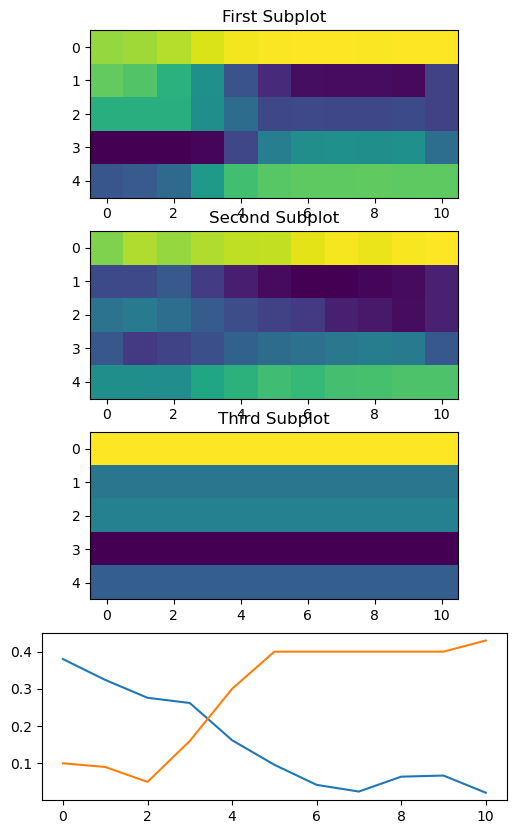

In [9]:
fig, axs = plt.subplots(4, 1, figsize=(6, 10))

# Plotting data in each subplot
axs[0].imshow(true_ranks.T)
axs[0].set_title('First Subplot')

axs[1].imshow(rf_ranks.T)
axs[1].set_title('Second Subplot')

axs[2].imshow(dummy_ranks.T)
axs[2].set_title('Third Subplot')

axs[3].plot(list(rf_ranks_error.pairwise_error))
axs[3].plot(list(dummy_ranks_error.pairwise_error))

In [10]:
#errors = {}
#feature_groups = list(np.unique([x[2] for x in list(generalization_dict.keys())]))
#meta_models = list(np.unique([x[0] for x in list(generalization_dict.keys())]))
#
#
#meta_model = 'RandomForestRegressor'
#for feature_group in feature_groups:
#    subset = [x for x in list(generalization_dict.keys()) if x[2]==feature_group and x[0]==meta_model]
#    alphas = np.array([generalization_dict[x][0] for x in subset]).mean(axis=0)
#    pw_errors = np.array([generalization_dict[x][1] for x in subset]).mean(axis=0)
#    errors[str(feature_group)] = (alphas, pw_errors)
#    
#meta_model = 'DummyRegressor'
#feature_group = 'all'
#subset = [x for x in list(generalization_dict.keys()) if x[2]==feature_group and x[0]==meta_model]
#alphas = np.array([generalization_dict[x][0] for x in subset]).mean(axis=0)
#pw_errors = np.array([generalization_dict[x][1] for x in subset]).mean(axis=0)
#errors['dummy'] = (alphas, pw_errors)

In [11]:
sdfsF=sdfsf

NameError: name 'sdfsf' is not defined

In [ ]:
#feature_groups = df.feature_group.unique()
#errors = {}
#vd = df.query('metamodel=="DummyRegressor"').groupby('alpha').mean(numeric_only=True).reset_index()
#errors['dummy'] = (list(vd.alpha), list(vd.pairwise_error))
#for feature_group in feature_groups:
#    print(feature_group)
#    vrf = df.query(f'metamodel=="RandomForestRegressor" and feature_group=="{feature_group}"').groupby('alpha').mean(numeric_only=True).reset_index()
#    errors[feature_group] = (list(vrf.alpha), list(vrf.pairwise_error))

In [ ]:
mapped = {
    'dummy': {'linestyle': '--', 'color':'black', 'linewidth':2},
    'all': {'linestyle': '-', 'color':'black', 'linewidth':2},
    'ela_level': {'color':'tab:blue'},
    'norm_ela_level': {'linestyle': '--', 'color':'tab:blue'},
    'cm_conv': {'color':'tab:orange'},
    'norm_cm_conv': {'linestyle': '--', 'color':'tab:orange'},
    'disp': {'color':'tab:green'},
    'norm_disp': {'linestyle': '--', 'color':'tab:green'},
    'limo': {'color':'tab:red'},
    'norm_limo': {'linestyle': '--', 'color':'tab:red'},
    'ic': {'color':'tab:purple'},
    'norm_ic': {'linestyle': '--', 'color':'tab:purple'},
    'pca': {'color':'tab:brown'},
    'norm_pca': {'linestyle': '--', 'color':'tab:brown'},
    'nbc': {'color':'tab:pink'},
    'norm_nbc': {'linestyle': '--', 'color':'tab:pink'},
    'ela_distr': {'color':'tab:gray'},
    'norm_ela_distr': {'linestyle': '--', 'color':'tab:gray'},
    'cm_grad': {'color':'tab:olive'},
    'norm_cm_grad': {'linestyle': '--', 'color':'tab:olive'},
    'cm_angle': {'color':'tab:cyan'},
    'norm_cm_angle': {'linestyle': '--', 'color':'tab:cyan'},
    'ela_meta': {'color':'yellow'},
    'norm_ela_meta': {'linestyle': '--', 'color':'yellow'},
    
}

plt.figure(figsize=(10, 10))
for feature_group, (alphas, values) in errors.items():
    print(feature_group)
    plt.plot(alphas, values, label=feature_group, **mapped[feature_group])
plt.legend()
plt.grid()
plt.savefig(f'figures/feature_group_error.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
#plt.figure(figsize=(15, 15))
#
#for feature_group in feature_groups:
#    print(feature_group)
#    vrf = df.query(f'metamodel=="RandomForestRegressor" and feature_group=="{feature_group}"').sample(10000).groupby('alpha').mean(numeric_only=True).reset_index()
#    plt.plot(list(vrf.alpha), list(vrf.pairwise_error), label=feature_group)
#vd = df.query('metamodel=="DummyRegressor"').sample(10000).groupby('alpha').mean(numeric_only=True).reset_index()
#plt.plot(list(vd.alpha), list(vd.pairwise_error), label='dummy')
#plt.legend()
#plt.show()

In [ ]:
#vd = df.query('metamodel=="DummyRegressor"').sample(10000).groupby('alpha').mean(numeric_only=True).reset_index()
#plt.plot(list(vd.alpha), list(vd.pairwise_error))
#vrf = df.query('metamodel=="RandomForestRegressor"').sample(10000).groupby('alpha').mean(numeric_only=True).reset_index()
#plt.plot(list(vrf.alpha), list(vrf.pairwise_error))
#plt.legend()